In [1]:
!pip install anaflow

In [2]:
import numpy as np
import sympy as sp
import anaflow
import scipy.special as sc
from scipy import integrate
import matplotlib.pyplot as plt
import pandas as pd
from mpmath import *
mp.dps = 15; mp.pretty = True

##Задача
###Рассмотрим неустановившийся приток жидкости к вертикальной скважине, полностью вскрывшей бесконечный однородный пласт толщины h с начальным давлением pi.

###Исходные данные

In [3]:
q = 0.00092 # [m3/c] - дебит скважины
B = 1.25 # [m3/m3] - объемный коэффициент
k = 5*1e-15 # [m2] - изотропная проницаемость
h = 9.144 # [m] - толщина пласта
f = 0.3 # [] - пористость
c = 1.47*1e-9 # [1/Pa] - сжимаемость флюида
cf = 1 * 1e-9 # [1/Pa] - сжимаемость породы
ct = (c + cf) # [1/Pa] - общая породы
rw = 0.1524 # [m] - радиус ствола скважины
r = 0.1524 # [m] - радиальная координата и расстояние
mu = 3*1e-3 # [Pa*c] - вязкость
eta = k / (mu * f * ct) # коэф пьезопроводности 

# Решение относительно распределения давления
$$ \Delta p(s) = \dfrac {qB\mu}{2\pi k h} \dfrac{K_0 (\sqrt{\dfrac{s}{\eta}}r)}{s\sqrt{\dfrac{s}{\eta}}r_w K_1(\sqrt{\dfrac{s}{\eta}}r_w)}$$

## Решение для линейного источника
$$ \Delta p(r,t) = - \dfrac {q B \mu} {4 \pi k h} E_i(- \dfrac {r^2} {4 \eta t})$$

In [4]:
# Решение для линейного источника
def pd_ei (r, t, q = q, B = B, k = k, h = h, mu = mu, eta = eta, f = f):
    return -q * B * mu /(4 * pi() * k * h)  * sc.expi(-r ** 2 /(4 * eta * t))

In [5]:
# Решение с учетом конечного радиуса скважины
def pd_lapl (s, r = r, r_w = rw, q = q, B = B, k = k, h = h, mu = mu, eta = eta, f = f):
    return q * B * mu / (2 * np.pi * k * h) * sc.kn(0, r * (s / eta) ** 0.5) /(s * r_w * (s / eta)** 0.5 * sc.kn(1, r_w * (s / eta) ** 0.5))

In [6]:
# Решение с учетом конечного радиуса скважины
def pd_lapl_1 (s, r = r, r_w = rw, q = q, B = B, k = k, h = h, mu = mu, eta = eta, f = f):
    return q * B * mu / (2 * pi() * k * h) * besselk(0, r * (s / eta) ** 0.5) /(s * r_w * (s / eta)** 0.5 * besselk(1, r_w * (s / eta) ** 0.5))

In [7]:
# реализация функции расчета безразмерного давления на основе преобразования Лапласа
def pd_line_source_lapl(r, t):
    fp = lambda p: pd_lapl_1(p)
    return invertlaplace(fp, t, method='stehfest', degree = 5)

pd_ls_func = np.vectorize(pd_line_source_lapl)

In [8]:
path = 'https://raw.githubusercontent.com/AvtomonovPavel/Method-of-sources/main/Examples/example_3.1.1'
df = pd.read_table(path, sep='\s+', engine = 'python')

Text(0, 0.5, 'dP, Па')

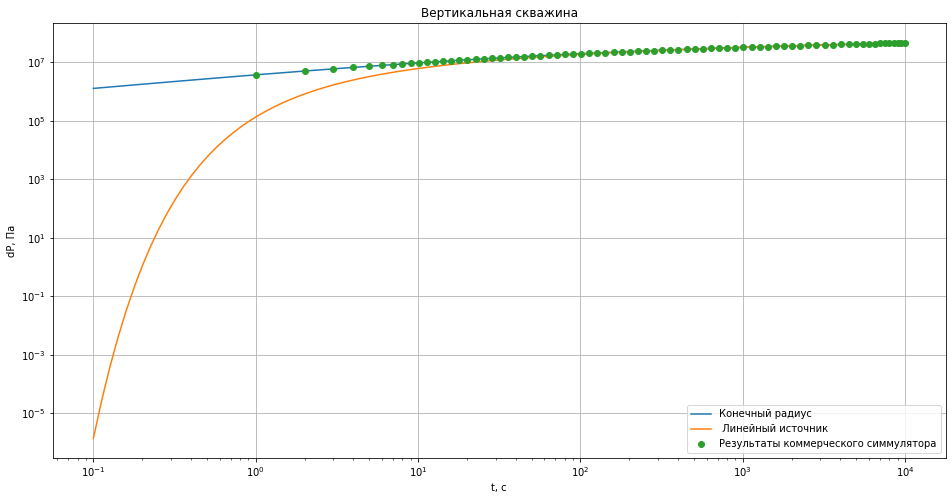

In [9]:
t = np.logspace(-1, 4, 100)
fig, ax1 = plt.subplots()
fig.set_size_inches(16, 8)
pd_ls = anaflow.get_lap_inv(pd_lapl)
ax1.plot(t, pd_ls(t), label = 'Конечный радиус ')
plt.title("Вертикальная скважина")
ax1.plot(t, pd_ei(r, t), label = ' Линейный источник')
ax1.plot(df['dTime'], df['p-p@dt=0'],'o', label = 'Результаты коммерческого симмулятора')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.legend()
ax1.grid()
plt.xlabel("t, c")
plt.ylabel("dP, Па")